In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

from sklearn.metrics import roc_auc_score, accuracy_score
from pathlib import Path

In [2]:
demo_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/Demographics.csv')
print(demo_df.shape)

demo_df.head(5)

(1837, 13)


,idx,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,SMOKER_N,SMOKER_Y
0,890,80.00,1,0,0,0,0,0,0,0,1,1,0
1,1879,64.12,0,1,0,0,0,0,0,0,1,0,1
2,1783,93.42,0,1,0,0,0,0,0,0,1,0,1
3,3896,93.82,1,0,0,0,0,0,0,0,1,1,0
4,1193,71.78,1,0,0,0,0,0,0,0,1,1,0


In [3]:
processed_demo_list = []

for df in [demo_df]:
    # remove zero variance featurs
    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    # set index 
    df = df.set_index('idx')

    # normalize features
    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_demo_list.append(df)

demo_df = pd.concat( processed_demo_list, axis=1 )

demo_df.head(5)

,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,SMOKER_N,SMOKER_Y
idx,,,,,,,,,,,,
890,0.648272,0.858799,-0.858799,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,0.477302,-0.477302
1879,-0.093297,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,-2.093970,2.093970
1783,1.274963,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,-2.093970,2.093970
3896,1.293643,0.858799,-0.858799,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,0.477302,-0.477302
1193,0.264412,0.858799,-0.858799,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,0.477302,-0.477302


In [4]:
out_med_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/OUT_MED.csv')
print(out_med_df.shape)

out_med_df.head(5)

(1837, 1283)


,idx,"Outpatient_LAXATIVES, LOCAL/RECTAL:Binary",Outpatient_PLATELET AGGREGATION INHIBITORS:Binary,Outpatient_nan:Binary,"Outpatient_NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","Outpatient_ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",Outpatient_ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,Outpatient_SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"Outpatient_VASODILATORS,CORONARY:Binary",Outpatient_ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,...,Outpatient_LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,Outpatient_THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,Outpatient_SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,Outpatient_ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,Outpatient_ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,Outpatient_FEEDING DEVICES:Frequeny,"Outpatient_DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","Outpatient_TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","Outpatient_ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","Outpatient_ACNE AGENTS,SYSTEMIC:Frequeny"
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1691,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
processed_out_med_list = []

for df in [out_med_df]:

    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    df = df.set_index('idx')

    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_out_med_list.append(df)

out_med_df = pd.concat( processed_out_med_list, axis=1 )

In [6]:
in_med_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/INP_MED.csv')
print(in_med_df.shape)

in_med_df.head(5)

(1837, 1283)


,idx,"LAXATIVES, LOCAL/RECTAL:Binary",PLATELET AGGREGATION INHIBITORS:Binary,nan:Binary,"NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"VASODILATORS,CORONARY:Binary",ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,...,LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,FEEDING DEVICES:Frequeny,"DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","ACNE AGENTS,SYSTEMIC:Frequeny"
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1691,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
processed_in_med_list = []

for df in [in_med_df]:

    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    df = df.set_index('idx')

    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_in_med_list.append(df)

in_med_df = pd.concat( processed_in_med_list, axis=1 )

In [8]:
icd_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/ICD.csv')
print(icd_df.shape)

icd_df.head(5)

(1837, 283)


,idx,MATERNAL CAUSES OF PERINATAL MORBIDITY AND MORTALITY:frequency,OTHER CONDITIONS ORIGINATING IN THE PERINATAL PERIOD:frequency,COMPLICATIONS MAINLY RELATED TO PREGNANCY:frequency,COMPLICATIONS OCCURRING MAINLY IN THE COURSE OF LABOR AND DELIVERY:frequency,COMPLICATIONS OF THE PUERPERIUM:frequency,ECTOPIC AND MOLAR PREGNANCY:frequency,"NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY:frequency",OTHER MATERNAL AND FETAL COMPLICATIONS:frequency,OTHER PREGNANCY WITH ABORTIVE OUTCOME:frequency,...,"Symptoms concerning nutrition, metabolism, and development:presence",Symptoms involving cardiovascular system:presence,Symptoms involving digestive system:presence,Symptoms involving head and neck:presence,Symptoms involving nervous and musculoskeletal systems:presence,Symptoms involving respiratory system and other chest symptoms:presence,Symptoms involving skin and other integumentary tissue:presence,Symptoms involving urinary system:presence,SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING:presence,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES:presence
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1691,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
processed_icd_list = []

for df in [icd_df]:

    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    df = df.set_index('idx')

    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_icd_list.append(df)

icd_df = pd.concat( processed_icd_list, axis=1 )

icd_df.shape

(1837, 258)

In [10]:
lab_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/LABS.csv')
print(lab_df.shape)

lab_df.head(5)

(1837, 45)


,idx,albumin:Binary,alk:Binary,ast:Binary,anion:Binary,bilirubin:Binary,bun:Binary,bun_cre:Binary,calcium:Binary,creatinine:Binary,...,hemoglobin:Value,a1c:Value,hgb:Value,inr:Value,lactate:Value,platelet:Value,potassium:Value,ptt:Value,sodium:Value,wbc:Value
0,84,1,1,1,1,1,1,0,0,1,...,7.9,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.3
1,2248,1,1,1,1,1,1,0,0,1,...,12.4,0.0,0.0,0.0,0.0,655.0,0.0,0.0,0.0,13.8
2,2271,1,1,1,1,1,1,0,0,1,...,10.9,0.0,0.0,1.3,0.0,356.0,0.0,15.9,0.0,6.8
3,1691,1,1,1,1,1,1,0,0,1,...,11.7,0.0,0.0,0.0,1.8,426.0,0.0,0.0,0.0,10.0
4,3286,1,1,1,1,1,1,0,0,1,...,12.7,0.0,0.0,2.0,0.0,131.0,0.0,21.7,0.0,4.0


In [11]:
processed_lab_list = []

for df in [lab_df]:

    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    df = df.set_index('idx')

    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_lab_list.append(df)

lab_df = pd.concat( processed_lab_list, axis=1 )

In [12]:
vitals_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/Vitals.csv')
print(vitals_df.shape)

vitals_df.head(5)

(1837, 10)


,idx,SBP,DBP,height_inch,weight_kg,bmi,tempf,respirations,spO2,pulse
0,84,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
1,2248,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
2,2271,0.0,-7.0,-48.5,-5.65,-38.985,44.30,-28.5,5.0,12.0
3,1691,5.0,0.0,-48.0,-1.90,-37.850,43.05,-28.5,4.5,18.0
4,3286,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0


In [13]:
processed_vitals_list = []

for df in [vitals_df]:

    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    df = df.set_index('idx')

    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_vitals_list.append(df)

vitals_df = pd.concat( processed_vitals_list, axis=1 )

In [14]:
vision_df = pd.read_csv('/home/bmlserver/jk/iPynb/NN/DATA/Vision.csv')
print(vision_df.shape)

vision_df.head(5)

(1837, 6)


,Unnamed: 0,idx,label,pred,pe_type,split
0,0,1436,0,0.405236,NaN,train
1,1,1880,1,0.836337,segmental,train
2,2,2738,0,0.596504,NaN,val
3,3,2883,0,0.108968,NaN,train
4,4,2302,1,0.808755,segmental,train


In [15]:
vision_df = vision_df.set_index('idx')

df_demo = pd.concat([vision_df, demo_df], axis=1)
df_outMed = pd.concat([vision_df, out_med_df], axis=1)
df_inMed = pd.concat([vision_df, in_med_df], axis=1)
df_icd = pd.concat([vision_df, icd_df], axis=1)
df_lab = pd.concat([vision_df, lab_df], axis=1)
df_vitals = pd.concat([vision_df, vitals_df], axis=1)

In [16]:
processed_emr_dfs = []
for df in [demo_df, out_med_df, in_med_df, icd_df, lab_df, vitals_df]:
    
    processed_emr_dfs.append(df)

emr_df = pd.concat(processed_emr_dfs, axis=1)

df_emr = pd.concat([vision_df, emr_df], axis=1)

In [17]:
DEMO_EMR_FEATURE_COLS = demo_df.columns.tolist()
OUTMED_EMR_FEATURE_COLS = out_med_df.columns.tolist()
INMED_EMR_FEATURE_COLS = in_med_df.columns.tolist()
ICD_EMR_FEATURE_COLS = icd_df.columns.tolist()
LAB_EMR_FEATURE_COLS = lab_df.columns.tolist()
VITALS_EMR_FEATURE_COLS = vitals_df.columns.tolist()
PE_TYPE_COL = 'pe_type'
SPLIT_COL = 'split'
VISION_PRED_COL = 'pred'
EMR_PRED_COL = 'emr_pred'
DEMO_PRED_COL = 'demo_pred'
OUTMED_PRED_COL = 'outMed_pred'
INMED_PRED_COL = 'inMed_pred'
ICD_PRED_COL = 'icd_pred'
VITAL_PRED_COL = 'vital_pred'
FUSION_PRED_COL = 'late_fusion_pred'
LABEL_COL = 'label'

In [18]:
### split Train / Test / Validation ###

demo_df_train = df_demo[df_demo[SPLIT_COL] == 'train']
demo_df_val = df_demo[df_demo[SPLIT_COL] == 'val']
demo_df_test = df_demo[df_demo[SPLIT_COL] == 'test']

In [19]:
### DF to NP ###

demoX_train = demo_df_train[DEMO_EMR_FEATURE_COLS].to_numpy()
demoX_test = demo_df_test[DEMO_EMR_FEATURE_COLS].to_numpy()
demoX_valid = demo_df_val[DEMO_EMR_FEATURE_COLS].to_numpy()
demoy_train = demo_df_train[LABEL_COL].to_numpy()
demoy_test = demo_df_test[LABEL_COL].to_numpy()
demoy_valid = demo_df_val[LABEL_COL].to_numpy()

In [20]:
### NP to torchTensor ###

demo_TT_X_train = torch.from_numpy(demoX_train).float()
demo_TT_X_test = torch.from_numpy(demoX_test).float()
demo_TT_X_valid = torch.from_numpy(demoX_valid).float()
demo_TT_y_train = torch.from_numpy(demoy_train).float().view(-1, 1)
demo_TT_y_test = torch.from_numpy(demoy_test).float().view(-1, 1)
demo_TT_y_valid = torch.from_numpy(demoy_valid).float().view(-1, 1)

In [21]:
demo_dataset_train = TensorDataset(demo_TT_X_train, demo_TT_y_train)
demo_dataloader_train = DataLoader(demo_dataset_train, batch_size=demo_TT_X_test.shape[0])
demo_dataset_val = TensorDataset(demo_TT_X_valid, demo_TT_y_valid)
demo_dataloader_val = DataLoader(demo_dataset_val, batch_size=demo_TT_X_valid.shape[0])
demo_dataset_test = TensorDataset(demo_TT_X_test, demo_TT_y_test)
demo_dataloader_test = DataLoader(demo_dataset_test, batch_size=demo_TT_X_test.shape[0])

In [22]:
### split Train / Test / Validation ###

inMed_df_train = df_inMed[df_inMed[SPLIT_COL] == 'train']
inMed_df_val = df_inMed[df_inMed[SPLIT_COL] == 'val']
inMed_df_test = df_inMed[df_inMed[SPLIT_COL] == 'test']

In [23]:
### DF to NP ###

inMedX_train = inMed_df_train[INMED_EMR_FEATURE_COLS].to_numpy()
inMedX_test = inMed_df_test[INMED_EMR_FEATURE_COLS].to_numpy()
inMedX_valid = inMed_df_val[INMED_EMR_FEATURE_COLS].to_numpy()
inMedy_train = inMed_df_train[LABEL_COL].to_numpy()
inMedy_test = inMed_df_test[LABEL_COL].to_numpy()
inMedy_valid = inMed_df_val[LABEL_COL].to_numpy()

In [24]:
### NP to torchTensor ###

inMed_TT_X_train = torch.from_numpy(inMedX_train).float()
inMed_TT_X_test = torch.from_numpy(inMedX_test).float()
inMed_TT_X_valid = torch.from_numpy(inMedX_valid).float()
inMed_TT_y_train = torch.from_numpy(inMedy_train).float().view(-1, 1)
inMed_TT_y_test = torch.from_numpy(inMedy_test).float().view(-1, 1)
inMed_TT_y_valid = torch.from_numpy(inMedy_valid).float().view(-1, 1)

In [25]:
inMed_dataset_train = TensorDataset(inMed_TT_X_train, inMed_TT_y_train)
inMed_dataloader_train = DataLoader(inMed_dataset_train, batch_size=inMed_TT_X_test.shape[0])
inMed_dataset_val = TensorDataset(inMed_TT_X_valid, inMed_TT_y_valid)
inMed_dataloader_val = DataLoader(inMed_dataset_val, batch_size=inMed_TT_X_valid.shape[0])
inMed_dataset_test = TensorDataset(inMed_TT_X_test, inMed_TT_y_test)
inMed_dataloader_test = DataLoader(inMed_dataset_test, batch_size=inMed_TT_X_test.shape[0])

In [26]:
### split Train / Test / Validation ###

outMed_df_train = df_outMed[df_outMed[SPLIT_COL] == 'train']
outMed_df_val = df_outMed[df_outMed[SPLIT_COL] == 'val']
outMed_df_test = df_outMed[df_outMed[SPLIT_COL] == 'test']

In [27]:
### DF to NP ###

outMedX_train = outMed_df_train[OUTMED_EMR_FEATURE_COLS].to_numpy()
outMedX_test = outMed_df_test[OUTMED_EMR_FEATURE_COLS].to_numpy()
outMedX_valid = outMed_df_val[OUTMED_EMR_FEATURE_COLS].to_numpy()
outMedy_train = outMed_df_train[LABEL_COL].to_numpy()
outMedy_test = outMed_df_test[LABEL_COL].to_numpy()
outMedy_valid = outMed_df_val[LABEL_COL].to_numpy()

In [28]:
### NP to torchTensor ###

outMed_TT_X_train = torch.from_numpy(outMedX_train).float()
outMed_TT_X_test = torch.from_numpy(outMedX_test).float()
outMed_TT_X_valid = torch.from_numpy(outMedX_valid).float()
outMed_TT_y_train = torch.from_numpy(outMedy_train).float().view(-1, 1)
outMed_TT_y_test = torch.from_numpy(outMedy_test).float().view(-1, 1)
outMed_TT_y_valid = torch.from_numpy(outMedy_valid).float().view(-1, 1)

In [29]:
outMed_dataset_train = TensorDataset(outMed_TT_X_train, outMed_TT_y_train)
outMed_dataloader_train = DataLoader(outMed_dataset_train, batch_size=outMed_TT_X_test.shape[0])
outMed_dataset_val = TensorDataset(outMed_TT_X_valid, outMed_TT_y_valid)
outMed_dataloader_val = DataLoader(outMed_dataset_val, batch_size=outMed_TT_X_valid.shape[0])
outMed_dataset_test = TensorDataset(outMed_TT_X_test, outMed_TT_y_test)
outMed_dataloader_test = DataLoader(outMed_dataset_test, batch_size=outMed_TT_X_test.shape[0])

In [30]:
### split Train / Test / Validation ###

icd_df_train = df_icd[df_icd[SPLIT_COL] == 'train']
icd_df_val = df_icd[df_icd[SPLIT_COL] == 'val']
icd_df_test = df_icd[df_icd[SPLIT_COL] == 'test']

In [31]:
### DF to NP ###

icdX_train = icd_df_train[ICD_EMR_FEATURE_COLS].to_numpy()
icdX_test = icd_df_test[ICD_EMR_FEATURE_COLS].to_numpy()
icdX_valid = icd_df_val[ICD_EMR_FEATURE_COLS].to_numpy()
icdy_train = icd_df_train[LABEL_COL].to_numpy()
icdy_test = icd_df_test[LABEL_COL].to_numpy()
icdy_valid = icd_df_val[LABEL_COL].to_numpy()

In [32]:
### NP to torchTensor ###

icd_TT_X_train = torch.from_numpy(icdX_train).float()
icd_TT_X_test = torch.from_numpy(icdX_test).float()
icd_TT_X_valid = torch.from_numpy(icdX_valid).float()
icd_TT_y_train = torch.from_numpy(icdy_train).float().view(-1, 1)
icd_TT_y_test = torch.from_numpy(icdy_test).float().view(-1, 1)
icd_TT_y_valid = torch.from_numpy(icdy_valid).float().view(-1, 1)

In [33]:
icd_dataset_train = TensorDataset(icd_TT_X_train, icd_TT_y_train)
icd_dataloader_train = DataLoader(icd_dataset_train, batch_size=icd_TT_X_test.shape[0])
icd_dataset_val = TensorDataset(icd_TT_X_valid, icd_TT_y_valid)
icd_dataloader_val = DataLoader(icd_dataset_val, batch_size=icd_TT_X_valid.shape[0])
icd_dataset_test = TensorDataset(icd_TT_X_test, icd_TT_y_test)
icd_dataloader_test = DataLoader(icd_dataset_test, batch_size=icd_TT_X_test.shape[0])

In [34]:
### split Train / Test / Validation ###

lab_df_train = df_lab[df_lab[SPLIT_COL] == 'train']
lab_df_val = df_lab[df_lab[SPLIT_COL] == 'val']
lab_df_test = df_lab[df_lab[SPLIT_COL] == 'test']

In [35]:
### DF to NP ###

labX_train = lab_df_train[LAB_EMR_FEATURE_COLS].to_numpy()
labX_test = lab_df_test[LAB_EMR_FEATURE_COLS].to_numpy()
labX_valid = lab_df_val[LAB_EMR_FEATURE_COLS].to_numpy()
laby_train = lab_df_train[LABEL_COL].to_numpy()
laby_test = lab_df_test[LABEL_COL].to_numpy()
laby_valid = lab_df_val[LABEL_COL].to_numpy()

In [36]:
### NP to torchTensor ###

lab_TT_X_train = torch.from_numpy(labX_train).float()
lab_TT_X_test = torch.from_numpy(labX_test).float()
lab_TT_X_valid = torch.from_numpy(labX_valid).float()
lab_TT_y_train = torch.from_numpy(laby_train).float().view(-1, 1)
lab_TT_y_test = torch.from_numpy(laby_test).float().view(-1, 1)
lab_TT_y_valid = torch.from_numpy(laby_valid).float().view(-1, 1)

In [37]:
lab_dataset_train = TensorDataset(lab_TT_X_train, lab_TT_y_train)
lab_dataloader_train = DataLoader(lab_dataset_train, batch_size=lab_TT_X_test.shape[0])
lab_dataset_val = TensorDataset(lab_TT_X_valid, lab_TT_y_valid)
lab_dataloader_val = DataLoader(lab_dataset_val, batch_size=lab_TT_X_valid.shape[0])
lab_dataset_test = TensorDataset(lab_TT_X_test, lab_TT_y_test)
lab_dataloader_test = DataLoader(lab_dataset_test, batch_size=lab_TT_X_test.shape[0])\

SyntaxError: unexpected EOF while parsing (1790309306.py, line 6)

In [ ]:
### split Train / Test / Validation ###

vital_df_train = df_vitals[df_vitals[SPLIT_COL] == 'train']
vital_df_val = df_vitals[df_vitals[SPLIT_COL] == 'val']
vital_df_test = df_vitals[df_vitals[SPLIT_COL] == 'test']

In [ ]:
### DF to NP ###

vitalX_train = vital_df_train[VITALS_EMR_FEATURE_COLS].to_numpy()
vitalX_test = vital_df_test[VITALS_EMR_FEATURE_COLS].to_numpy()
vitalX_valid = vital_df_val[VITALS_EMR_FEATURE_COLS].to_numpy()
vitaly_train = vital_df_train[LABEL_COL].to_numpy()
vitaly_test = vital_df_test[LABEL_COL].to_numpy()
vitaly_valid = vital_df_val[LABEL_COL].to_numpy()

In [ ]:
### NP to torchTensor ###

vital_TT_X_train = torch.from_numpy(vitalX_train).float()
vital_TT_X_test = torch.from_numpy(vitalX_test).float()
vital_TT_X_valid = torch.from_numpy(vitalX_valid).float()
vital_TT_y_train = torch.from_numpy(vitaly_train).float().view(-1, 1)
vital_TT_y_test = torch.from_numpy(vitaly_test).float().view(-1, 1)
vital_TT_y_valid = torch.from_numpy(vitaly_valid).float().view(-1, 1)

In [ ]:
vital_dataset_train = TensorDataset(vital_TT_X_train, vital_TT_y_train)
vital_dataloader_train = DataLoader(vital_dataset_train, batch_size=vital_TT_X_test.shape[0])
vital_dataset_val = TensorDataset(vital_TT_X_valid, vital_TT_y_valid)
vital_dataloader_val = DataLoader(vital_dataset_val, batch_size=vital_TT_X_valid.shape[0])
vital_dataset_test = TensorDataset(vital_TT_X_test, vital_TT_y_test)
vital_dataloader_test = DataLoader(vital_dataset_test, batch_size=vital_TT_X_test.shape[0])

In [ ]:
class mmPT(pl.LightningModule):
    def __init__(
        self, loss_fn, n_inputs: int = 1, learning_rate=0.02, l1_lambda=0.02, l2_lambda=0.02
        ):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.output_layer = torch.nn.Linear(n_inputs, 1)
        self.validation_log = []
        self.train_log = []
        
    def forward(self, x):
        outputs = self.output_layer(x)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def l1_reg(self):
        l1_norm = self.output_layer.weight.abs().sum()

        return self.l1_lambda * l1_norm

    def l2_reg(self):
        l2_norm = self.output_layer.weight.pow(2).sum()
        
        return self.l2_lambda * l2_norm

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y) + self.l1_reg() + self.l2_reg()
        
        self.log("loss", loss)
        self.train_log.append(loss.detach().numpy())
        return loss

def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(train_loss)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Train loss')
    fig.show()

In [ ]:
demo_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=demo_TT_X_train.shape[1],
    l1_lambda=0.0,
    l2_lambda=0.0,
    learning_rate=0.02,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/bmlserver/anaconda3/envs/jk/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
/home/bmlserver/anaconda3/envs/jk/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
Missing logger folder: /home/bmlserver/jk/iPynb/mmF/lightning_logs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 13    
-----------------------------------------
13        Trainable params
0         Non-trainable params
13        Total

Training: 0it [00:00, ?it/s]

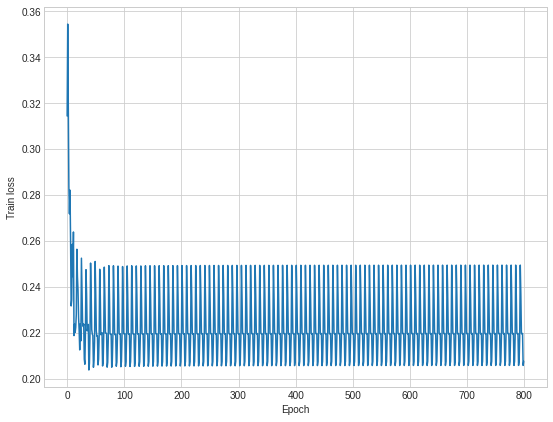

In [ ]:
# fit model
demo_trainer = pl.Trainer(max_epochs=100)
demo_trainer.fit(demo_model, demo_dataloader_train, demo_dataloader_val)

demo_w_model = np.append(
    demo_model.output_layer.bias.detach().numpy()[0],
    demo_model.output_layer.weight.detach().numpy(),
)

plot_convergence(demo_model.train_log)


In [ ]:
inMed_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=inMed_TT_X_train.shape[1],
    l1_lambda=0.002,
    l2_lambda=0.002,
    learning_rate=0.001,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 619   
-----------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

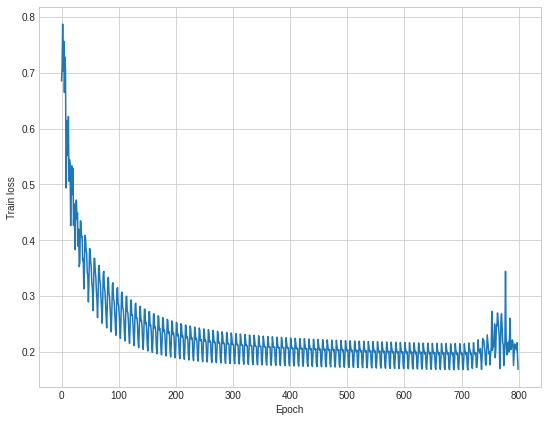

In [ ]:
# fit model
inMed_trainer = pl.Trainer(max_epochs=100)
inMed_trainer.fit(inMed_model, inMed_dataloader_train, inMed_dataloader_val)

inMed_w_model = np.append(
    inMed_model.output_layer.bias.detach().numpy()[0],
    inMed_model.output_layer.weight.detach().numpy(),
)

plot_convergence(inMed_model.train_log)

In [ ]:
outMed_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=outMed_TT_X_train.shape[1],
    l1_lambda=0.002,
    l2_lambda=0.002,
    learning_rate=0.001,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 567   
-----------------------------------------
567       Trainable params
0         Non-trainable params
567       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

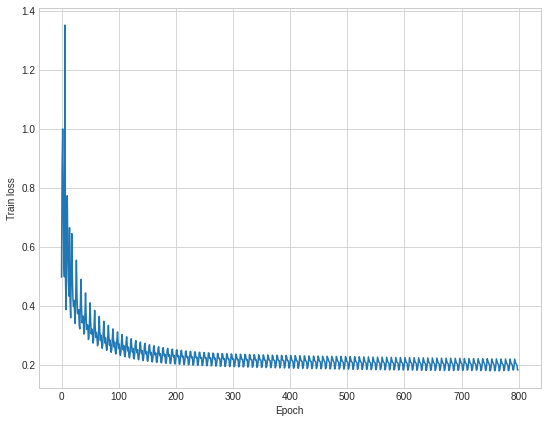

In [ ]:
# fit model
outMed_trainer = pl.Trainer(max_epochs=100)
outMed_trainer.fit(outMed_model, outMed_dataloader_train, outMed_dataloader_val)

outMed_w_model = np.append(
    outMed_model.output_layer.bias.detach().numpy()[0],
    outMed_model.output_layer.weight.detach().numpy(),
)

plot_convergence(outMed_model.train_log)

In [ ]:
icd_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=icd_TT_X_train.shape[1],
    l1_lambda=0.02,
    l2_lambda=0.02,
    learning_rate=0.002,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 259   
-----------------------------------------
259       Trainable params
0         Non-trainable params
259       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

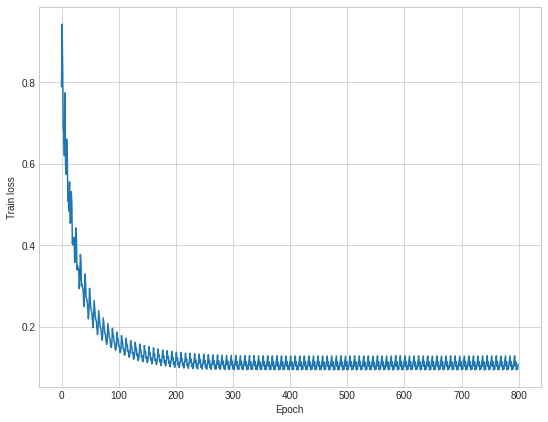

In [ ]:
# fit model
icd_trainer = pl.Trainer(max_epochs=100)
icd_trainer.fit(icd_model, icd_dataloader_train, icd_dataloader_val)

icd_w_model = np.append(
    icd_model.output_layer.bias.detach().numpy()[0],
    icd_model.output_layer.weight.detach().numpy(),
)

plot_convergence(icd_model.train_log)

In [ ]:
lab_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=lab_TT_X_train.shape[1],
    l1_lambda=0.02,
    l2_lambda=0.02,
    learning_rate=0.02,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 43    
-----------------------------------------
43        Trainable params
0         Non-trainable params
43        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

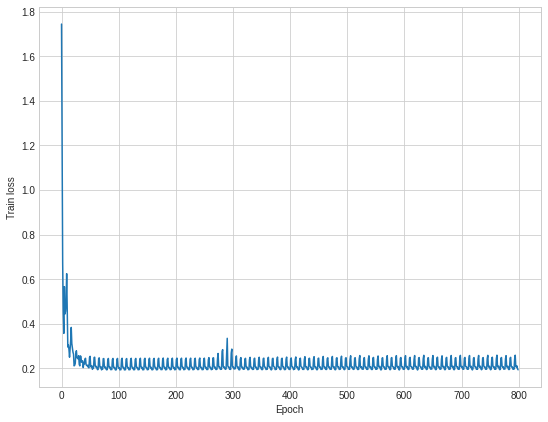

In [ ]:
# fit model
lab_trainer = pl.Trainer(max_epochs=100)
lab_trainer.fit(lab_model, lab_dataloader_train, lab_dataloader_val)

lab_w_model = np.append(
    lab_model.output_layer.bias.detach().numpy()[0],
    lab_model.output_layer.weight.detach().numpy(),
)

plot_convergence(lab_model.train_log)

In [ ]:
vital_model = mmPT(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=vital_TT_X_train.shape[1],
    l1_lambda=0.01,
    l2_lambda=0.01,
    learning_rate=0.02,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 10    
-----------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

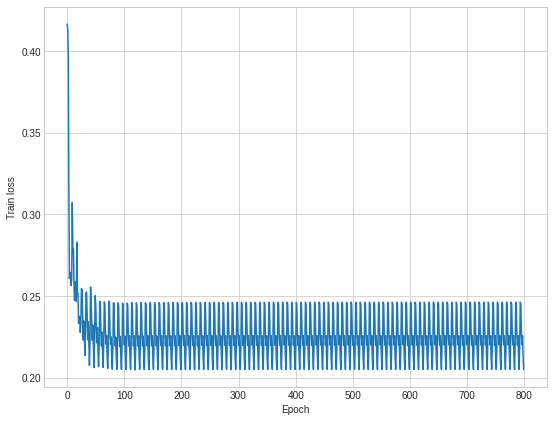

In [ ]:
# fit model
vital_trainer = pl.Trainer(max_epochs=100)
vital_trainer.fit(vital_model, vital_dataloader_train, vital_dataloader_val)

vital_w_model = np.append(
    vital_model.output_layer.bias.detach().numpy()[0],
    vital_model.output_layer.weight.detach().numpy(),
)

plot_convergence(vital_model.train_log)

In [ ]:
demo_prob = demo_trainer.predict(demo_model, demo_TT_X_test)
outMed_prob = outMed_trainer.predict(outMed_model, outMed_TT_X_test)
inMed_prob = inMed_trainer.predict(inMed_model, inMed_TT_X_test)
icd_prob = icd_trainer.predict(icd_model, icd_TT_X_test)
lab_prob = lab_trainer.predict(lab_model, lab_TT_X_test)
vital_prob = vital_trainer.predict(vital_model, vital_TT_X_test)

Predicting: 8it [00:00, ?it/s]

/home/bmlserver/anaconda3/envs/jk/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

In [ ]:
late_fusion_pred = np.mean(
    [demo_prob, inMed_prob, outMed_prob, icd_prob, lab_prob, vital_prob], 
    axis=0
)

/home/bmlserver/anaconda3/envs/jk/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/bmlserver/anaconda3/envs/jk/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, o

In [ ]:
df_emr_T = df_emr[df_emr[SPLIT_COL] == 'test']


emr_df = df_emr_T.assign(late_fusion_pred = late_fusion_pred)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_fusion, tpr_fusion, _ = metrics.roc_curve(
        emr_df[LABEL_COL], 
        emr_df[FUSION_PRED_COL])
roc_auc_fusion = metrics.auc(fpr_fusion, tpr_fusion)

In [ ]:
roc_auc_fusion

0.8139772727272726